
# Automatic Differentiation for ODEs  


This report documents Automatic Differentiation (AD) implementation and demos:

- `src/autodiff.hpp`
- `demos/demo_autodiff.cpp`
- `demos/legendre_poly_autodiff.cpp`
- `demos/plot_legendre.py`
- `demos/pendulum_autodiff.cpp`
- `demos/legendre_data.txt`


---

# 1. Numerical Differentiation vs Automatic Differentiation

## 1.1 Numerical Differentiation (Finite Differences)

For a scalar function $f : \mathbb{R}^N \to \mathbb{R}$, the partial derivative with respect to $x_i$ can be approximated by the symmetric difference quotient

$$
\frac{\partial f}{\partial x_i}(x)
\;\approx\;
\frac{f(x + \varepsilon e_i) - f(x - \varepsilon e_i)}{2\varepsilon},
$$

where $e_i$ is the $i$-th standard basis vector and $\varepsilon$ is small.

**Advantages**

- Very easy to implement.
- Works for any black-box function $f$.

**Disadvantages**

- Sensitive to cancellation and rounding when $\varepsilon$ is very small.
- Requires one function evaluation per dimension and direction.
- Only approximate.

---

## 1.2 Automatic Differentiation (Forward Mode)

In forward-mode automatic differentiation, every intermediate quantity $u$ in your computation is replaced by a pair

$$
u \;\mapsto\; (u, \nabla u) \in \mathbb{R} \times \mathbb{R}^N,
$$

where $\nabla u$ is the gradient of $u$ with respect to the independent variables.

The basic rules are:

### Sum

$$
w = u + v,
\qquad
\nabla w = \nabla u + \nabla v.
$$

### Product

$$
w = u\,v,
\qquad
\nabla w = u \,\nabla v + v \,\nabla u.
$$

### Quotient

$$
w = \frac{u}{v},
\qquad
\nabla w = \frac{v \nabla u - u \nabla v}{v^2}.
$$

### Sine

$$
w = \sin(u),
\qquad
\nabla w = \cos(u)\,\nabla u.
$$

### Cosine

$$
w = \cos(u),
\qquad
\nabla w = -\sin(u)\,\nabla u.
$$

### Exponential

$$
w = e^u,
\qquad
\nabla w = e^u \,\nabla u.
$$

### Logarithm

$$
w = \log(u),
\qquad
\nabla w = \frac{1}{u}\,\nabla u.
$$

C++ code in `autodiff.hpp` encodes exactly these rules as overloaded operators and functions.

---

# 2. Implementation: `src/autodiff.hpp`


```cpp
#ifndef AUTODIFF_HPP
#define AUTODIFF_HPP

#include <cstddef> 
#include <ostream> 
#include <cmath>   
#include <array>  

namespace ASC_ode
{

  template <size_t N, typename T = double>
  class Variable 
  {
    private:
      T m_val;
    public:
      Variable (T v) : m_val(v) {}
      T value() const { return m_val; }
  };

  template <typename T = double>
  auto derivative (T v, size_t /*index*/) { return T(0); } 

  template <size_t N, typename T = double>
  class AutoDiff
  {
  private:
    T m_val;
    std::array<T, N> m_deriv;
  public: 
    AutoDiff () : m_val(0), m_deriv{} {}
    AutoDiff (T v) : m_val(v), m_deriv{} 
    {
      for (size_t i = 0; i < N; i++)
        m_deriv[i] = derivative(v, i);
    }

    template <size_t I>
    AutoDiff (Variable<I, T> var) : m_val(var.value()), m_deriv{} 
    {
      m_deriv[I] = 1.0;
    }

    T value() const { return m_val; }
    std::array<T, N>& deriv() { return m_deriv; }
    const std::array<T, N>& deriv() const { return m_deriv; }
  };

  template <size_t N, typename T = double>
  auto derivative (AutoDiff<N, T> v, size_t index) 
  {
    return v.deriv()[index];
  }

  template <size_t N, typename T>
  std::ostream & operator<< (std::ostream& os, const AutoDiff<N, T>& ad)
  {
    os << "Value: " << ad.value() << ", Deriv: [";
    for (size_t i = 0; i < N; i++)
    {
      os << ad.deriv()[i];
      if (i < N - 1) os << ", ";
    }
    os << "]";
    return os;
  }
```

### 2.1 Basic Algebra: `+` and `*`

```cpp
  template <size_t N, typename T = double>
  AutoDiff<N, T> operator+ (const AutoDiff<N, T>& a, const AutoDiff<N, T>& b)
  {
     AutoDiff<N, T> result(a.value() + b.value());
     for (size_t i = 0; i < N; i++)
        result.deriv()[i] = a.deriv()[i] + b.deriv()[i];
     return result;
   }

   template <size_t N, typename T = double>
   auto operator+ (T a, const AutoDiff<N, T>& b) { return AutoDiff<N, T>(a) + b; }

   template <size_t N, typename T = double>
   AutoDiff<N, T> operator* (const AutoDiff<N, T>& a, const AutoDiff<N, T>& b)
   {
       AutoDiff<N, T> result(a.value() * b.value());
       for (size_t i = 0; i < N; i++)
          result.deriv()[i] = a.deriv()[i] * b.value() + a.value() * b.deriv()[i];
       return result;
   }
```

Mathematically, multiplication is the product rule:

$$
\nabla(fg) = f\nabla g + g\nabla f.
$$



### 2.2 Trigonometric and Additional Operators

```cpp
   using std::sin;
   using std::cos;

   template <size_t N, typename T = double>
   AutoDiff<N, T> sin(const AutoDiff<N, T> &a)
   {
       AutoDiff<N, T> result(sin(a.value()));
       for (size_t i = 0; i < N; i++)
           result.deriv()[i] = cos(a.value()) * a.deriv()[i];
       return result;
   }
```

The rest of the header extends AutoDiff with `-`, `/`, `cos`, `exp`, `log`, and scalar multiplications:

```cpp
   // -------------------------------------------------------------
   // Additional operators for Exercise 18.4
   // -------------------------------------------------------------

   // a - b
   template <size_t N, typename T = double>
   AutoDiff<N,T> operator- (const AutoDiff<N,T>& a, const AutoDiff<N,T>& b)
   {
       AutoDiff<N,T> result(a.value() - b.value());
       for (size_t i = 0; i < N; i++)
           result.deriv()[i] = a.deriv()[i] - b.deriv()[i];
       return result;
   }

   // scalar - AutoDiff
   template <size_t N, typename T = double>
   AutoDiff<N,T> operator- (T a, const AutoDiff<N,T>& b)
   {
       AutoDiff<N,T> aa(a);
       return aa - b;
   }

   // AutoDiff - scalar
   template <size_t N, typename T = double>
   AutoDiff<N,T> operator- (const AutoDiff<N,T>& a, T b)
   {
       AutoDiff<N,T> bb(b);
       return a - bb;
   }

   // a / b
   template <size_t N, typename T = double>
   AutoDiff<N,T> operator/ (const AutoDiff<N,T>& a, const AutoDiff<N,T>& b)
   {
       AutoDiff<N,T> result(a.value() / b.value());
       double denom = b.value() * b.value();
       for (size_t i = 0; i < N; i++)
           result.deriv()[i] =
              (a.deriv()[i] * b.value() - a.value() * b.deriv()[i]) / denom;
       return result;
   }

   // AutoDiff / scalar
   template <size_t N, typename T = double>
   AutoDiff<N,T> operator/ (const AutoDiff<N,T>& a, T b)
   {
       AutoDiff<N,T> bb(b);
       return a / bb;
   }

   // scalar / AutoDiff
   template <size_t N, typename T = double>
   AutoDiff<N,T> operator/ (T a, const AutoDiff<N,T>& b)
   {
       AutoDiff<N,T> aa(a);
       return aa / b;
   }

   // -------------------------------------------------------------
   // Additional functions: cos, exp, log
   // -------------------------------------------------------------

   template <size_t N, typename T = double>
   AutoDiff<N,T> cos(const AutoDiff<N,T>& a)
   {
       AutoDiff<N,T> result(::cos(a.value()));
       for (size_t i = 0; i < N; i++)
           result.deriv()[i] = -::sin(a.value()) * a.deriv()[i];
       return result;
   }

   template <size_t N, typename T = double>
   AutoDiff<N,T> exp(const AutoDiff<N,T>& a)
   {
       AutoDiff<N,T> result(::exp(a.value()));
       for (size_t i = 0; i < N; i++)
           result.deriv()[i] = result.value() * a.deriv()[i];
       return result;
   }

   template <size_t N, typename T = double>
   AutoDiff<N,T> log(const AutoDiff<N,T>& a)
   {
       AutoDiff<N,T> result(::log(a.value()));
       for (size_t i = 0; i < N; i++)
           result.deriv()[i] = a.deriv()[i] / a.value();
       return result;
   }

   // AutoDiff * scalar
   template <size_t N, typename T = double>
   AutoDiff<N,T> operator* (const AutoDiff<N,T>& a, T b)
   {
       AutoDiff<N,T> r(a.value() * b);
       for (size_t i = 0; i < N; i++)
           r.deriv()[i] = a.deriv()[i] * b;
       return r;
   }

   // scalar * AutoDiff
   template <size_t N, typename T = double>
   AutoDiff<N,T> operator* (T a, const AutoDiff<N,T>& b)
   {
       AutoDiff<N,T> r(a * b.value());
       for (size_t i = 0; i < N; i++)
           r.deriv()[i] = a * b.deriv()[i];
       return r;
   }

} // namespace ASC_ode

#endif
```

This completes the AD class used in the rest of the demos.

---

# 3. Demo: `demo_autodiff.cpp`

This file demonstrates:

- Basic usage of `AutoDiff<2>`,
- Comparing AD derivatives with numerical finite differences,
- Second derivatives via nested `AutoDiff`.

```cpp
#include <iostream>
#include <autodiff.hpp>

using namespace ASC_ode;

template <typename T>
T func1 (T x, T y)
{
  return x * sin(y);
  // return 1e6 + y;
}

int main()
{
  double x = 1, y = 2;
  AutoDiff<2> adx = Variable<0>(x);
  AutoDiff<2> ady = Variable<1>(y);

  std::cout << "adx = " << adx << std::endl;
  std::cout << "ady = " << ady << std::endl;

  AutoDiff<2> prod = adx * ady;
  std::cout << "prod = " << prod << std::endl;

  std::cout << "func1(adx, ady) = " << func1(adx, ady) << std::endl;

  double eps = 1e-8;
  std::cout << "numdiff df/dx = "
            << (func1(x + eps, y) - func1(x-eps, y)) / (2*eps)
            << std::endl;
  std::cout << "numdiff df/dy = "
            << (func1(x, y + eps) - func1(x, y-eps)) / (2*eps)
            << std::endl;

  {
    // we can do second derivatives:
    AutoDiff<1, AutoDiff<1>> addx{Variable<0>(2)};
    std::cout << "addx = " << addx << std::endl;
    // func = x*x
    // func' = 2*x
    // func'' = 2
    std::cout << "addx*addx = " << addx * addx << std::endl;

    // std::cout << "sin(addx) = " << sin(addx) << std::endl;
  }
  return 0;
}
```

For the function

$$
f(x,y) = x \sin(y)
$$

we have:

$$
\frac{\partial f}{\partial x} = \sin(y),
\qquad
\frac{\partial f}{\partial y} = x \cos(y).
$$

At $(x,y) = (1,2)$, the demo prints:

- AD-computed derivatives from `adx` and `ady`.
- Finite difference approximations in C++ using `eps=1e-8`.



The nested `AutoDiff<1, AutoDiff<1>>` demonstrates that you can obtain second derivatives automatically by using AutoDiff as the scalar type inside another AutoDiff.

---

# 4. Legendre Polynomials with AutoDiff

The Legendre polynomials are defined recursively:

$$
P_0(x) = 1,
\qquad
P_1(x) = x,
$$

$$
P_n(x) =
\frac{2n-1}{n} \, x \, P_{n-1}(x)
-
\frac{n-1}{n} \, P_{n-2}(x),
\quad n \ge 2.
$$

We implemented this using `AutoDiff` to also get derivatives.

## 4.1 C++: `legendre_poly_autodiff.cpp`

```cpp
#include <iostream>
#include <vector>

#include "../src/autodiff.hpp"

using namespace ASC_ode;

// ---------------------------------------------------------
// Build Legendre polynomials P0..P5 using recursion
// ---------------------------------------------------------
template <size_t N, typename T = double>
std::vector<AutoDiff<N,T>> Legendre(const AutoDiff<N,T>& x)
{
    std::vector<AutoDiff<N,T>> P(6);

    P[0] = AutoDiff<N,T>(1.0);
    P[1] = x;

    for (int n = 2; n <= 5; n++)
    {
        double a = (2.0*n - 1.0)/n;
        double b = (n - 1.0)/n;
        P[n] = a * x * P[n-1] - b * P[n-2];
    }

    return P;
}

// ---------------------------------------------------------
// MAIN: prints values and derivatives for P0..P5 on [-1,1]
// ---------------------------------------------------------
int main()
{
    const int N = 1; // only x is the variable

    std::cout << "x   P0  dP0  P1  dP1  P2  dP2  P3  dP3  P4  dP4  P5  dP5\n";

    for (int i = 0; i <= 40; i++)
    {
        double xv = -1.0 + 2.0 * i / 40.0;

        AutoDiff<N> x = Variable<0,double>(xv);

        auto P = Legendre<N>(x);

        std::cout << xv << " ";
        for (int n = 0; n <= 5; n++)
        {
            std::cout << P[n].value() << " " << P[n].deriv()[0] << "  ";
        }
        std::cout << "\n";
    }
    return 0;
}
```

This program prints a table with columns:

- `x`
- `P0 dP0`
- `P1 dP1`
- ...
- `P5 dP5`

to standard output, which you capture into `legendre_data.txt`.

A sample of `legendre_data.txt` (first line and one row):

```text
x   P0  dP0  P1  dP1  P2  dP2  P3  dP3  P4  dP4  P5  dP5
-1  1   0   -1   1    1  -3   -1   6    1 -10   -1  15
...
```

---

## 4.2 Python Plotting: `plot_legendre.py`

```python
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("legendre_data.txt", skiprows=1)

x = data[:,0]

# P0..P5 and derivatives
P = [data[:, 1 + 2*n] for n in range(6)]
dP = [data[:, 2 + 2*n] for n in range(6)]

# ------- Plot Polynomials -------
plt.figure(figsize=(10,6))
for n in range(6):
    plt.plot(x, P[n], label=f"P{n}(x)")
plt.title("Legendre Polynomials P0–P5")
plt.xlabel("x")
plt.ylabel("P_n(x)")
plt.grid(True)
plt.legend()
plt.show()

# ------- Plot Derivatives -------
plt.figure(figsize=(10,6))
for n in range(6):
    plt.plot(x, dP[n], label=f"P{n}'(x)")
plt.title("Derivatives of Legendre Polynomials")
plt.xlabel("x")
plt.ylabel("P_n'(x)")
plt.grid(True)
plt.legend()
plt.show()
```

This script reproduces the two main plots required by the assignment:

1. The polynomials $P_0,\dots,P_5$ on $[-1,1]$.
2. Their derivatives $P_0',\dots,P_5'$ on $[-1,1]$, obtained **directly from AutoDiff**, not from analytic formulas.

---

# 5. Pendulum ODE with AutoDiff

The nonlinear pendulum equation is:

$$
\alpha''(t) = -\frac{g}{l} \sin(\alpha(t)).
$$

Introduce

$$
y =
\begin{pmatrix}
y_0 \\[2pt]
y_1
\end{pmatrix}
=
\begin{pmatrix}
\alpha \\[2pt]
\alpha'
\end{pmatrix},
$$

then the first-order system is:

$$
y' = f(y) =
\begin{pmatrix}
y_1 \\
-\dfrac{g}{l} \sin(y_0)
\end{pmatrix}.
$$

## 5.1 Right-Hand Side and Jacobian in C++: `pendulum_autodiff.cpp`

```cpp
#include <iostream>
#include "../src/autodiff.hpp"

using namespace ASC_ode;

const double g = 9.81;
const double l = 1.0;

// -----------------------------------------------------
// Generic pendulum RHS: works for double AND AutoDiff
// -----------------------------------------------------
template <typename T>
std::array<T,2> T_evaluate(const std::array<T,2> &y)
{
    std::array<T,2> f;

    f[0] = y[1];
    f[1] = - (g/l) * sin(y[0]);

    return f;
}

int main()
{
    std::cout << "=== TEST PENDULUM RHS WITH DOUBLE ===\n";

    std::array<double,2> y_double = {1.0, 0.2};

    auto f_val = T_evaluate<double>(y_double);

    std::cout << "f0 = " << f_val[0] << "\n";
    std::cout << "f1 = " << f_val[1] << "\n";


    std::cout << "\n=== TEST PENDULUM RHS WITH AUTODIFF<J> ===\n";

    // 2 variables -> Jacobian is 2×2
    std::array<AutoDiff<2>,2> y_AD;
    y_AD[0] = Variable<0,double>(1.0);  // y0 = alpha
    y_AD[1] = Variable<1,double>(0.2);  // y1 = alpha'

    auto f_AD = T_evaluate<AutoDiff<2>>(y_AD);

    // Print values
    std::cout << "f0 value = " << f_AD[0].value() << "\n";
    std::cout << "f1 value = " << f_AD[1].value() << "\n";

    // Print Jacobian entries df_i/dy_j
    std::cout << "\nJacobian:\n";
    for(int i=0;i<2;i++)
    {
        for(int j=0;j<2;j++)
            std::cout << f_AD[i].deriv()[j] << "  ";
        std::cout << "\n";
    }

    return 0;
}
```

When `T` is `AutoDiff<2>`, every component of `f(y)` has a gradient w.r.t. $y_0,y_1$, giving the **Jacobian matrix** of $f$.

### 5.2 Analytical Jacobian

From

$$
f(y) =
\begin{pmatrix}
y_1 \\
-\dfrac{g}{l} \sin(y_0)
\end{pmatrix},
$$

we obtain:

$$
Df(y) =
\begin{pmatrix}
\partial f_0/\partial y_0 & \partial f_0/\partial y_1 \\
\partial f_1/\partial y_0 & \partial f_1/\partial y_1
\end{pmatrix}
=
\begin{pmatrix}
0 & 1 \\
-\dfrac{g}{l}\cos(y_0) & 0
\end{pmatrix}.
$$

A Python script to compare numerical and exact Jacobian:

```python
import numpy as np

g = 9.81
l = 1.0

def pendulum_rhs(y):
    alpha, alpha_dot = y
    return np.array([alpha_dot, -(g/l)*np.sin(alpha)])

def jacobian_fd(y, eps=1e-8):
    f0 = pendulum_rhs(y)
    J = np.zeros((2, 2))
    for j in range(2):
        y_plus = y.copy()
        y_minus = y.copy()
        y_plus[j] += eps
        y_minus[j] -= eps
        f_plus = pendulum_rhs(y_plus)
        f_minus = pendulum_rhs(y_minus)
        J[:, j] = (f_plus - f_minus) / (2*eps)
    return J

def jacobian_exact(y):
    alpha, alpha_dot = y
    return np.array([[0.0, 1.0],
                     [-(g/l)*np.cos(alpha), 0.0]])

y_test = np.array([1.0, 0.2])
print("J_num =\n", jacobian_fd(y_test))
print("J_ex  =\n", jacobian_exact(y_test))
```



---

# 6. How to Compile and Run Everything

## 6.1 Legendre Demo

```bash
cd build
make legendre_poly_autodiff    # or your CMake target name
./legendre_poly_autodiff > legendre_data.txt
```

Then:

```bash
python3 demos/plot_legendre.py
```

(or run inside your environment) to get the polynomial and derivative plots.

## 6.2 Pendulum Demo

```bash
cd build
make pendulum_autodiff
./pendulum_autodiff
```

Check the printed Jacobian entries against the analytical matrix.

## 6.3 AutoDiff Demo

```bash
cd build
make demo_autodiff
./demo_autodiff
```

Compare:

- AD derivatives with
- Numerical finite differences & analytic formulas.


In [1]:
import numpy as np

def f_xy(x, y):
    return x * np.sin(y)

x, y = 1.0, 2.0
eps = 1e-8

df_dx_num = (f_xy(x+eps, y) - f_xy(x-eps, y)) / (2*eps)
df_dy_num = (f_xy(x, y+eps) - f_xy(x, y-eps)) / (2*eps)

df_dx_exact = np.sin(y)
df_dy_exact = x * np.cos(y)

print("df/dx (num, exact):", df_dx_num, df_dx_exact)
print("df/dy (num, exact):", df_dy_num, df_dy_exact)

df/dx (num, exact): 0.9092974262436826 0.9092974268256817
df/dy (num, exact): -0.4161468336594254 -0.4161468365471424


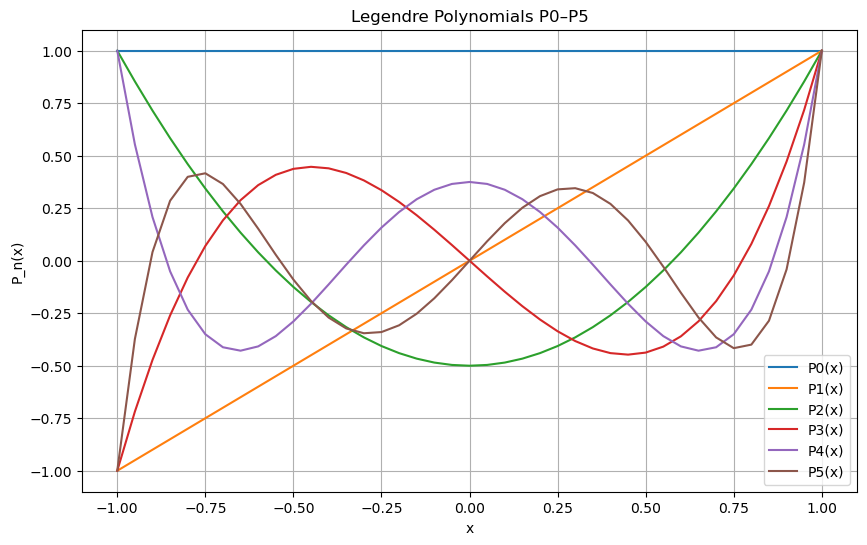

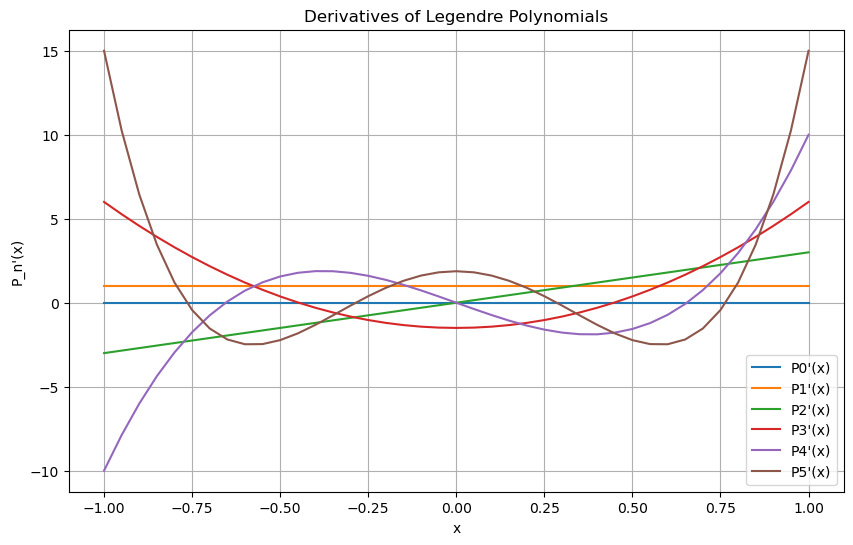

In [2]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("legendre_data.txt", skiprows=1)

x = data[:,0]

# P0..P5 and derivatives
P = [data[:, 1 + 2*n] for n in range(6)]
dP = [data[:, 2 + 2*n] for n in range(6)]

# ------- Plot Polynomials -------
plt.figure(figsize=(10,6))
for n in range(6):
    plt.plot(x, P[n], label=f"P{n}(x)")
plt.title("Legendre Polynomials P0–P5")
plt.xlabel("x")
plt.ylabel("P_n(x)")
plt.grid(True)
plt.legend()
plt.show()

# ------- Plot Derivatives -------
plt.figure(figsize=(10,6))
for n in range(6):
    plt.plot(x, dP[n], label=f"P{n}'(x)")
plt.title("Derivatives of Legendre Polynomials")
plt.xlabel("x")
plt.ylabel("P_n'(x)")
plt.grid(True)
plt.legend()
plt.show()

In [2]:
import numpy as np

g = 9.81
l = 1.0

def pendulum_rhs(y):
    alpha, alpha_dot = y
    return np.array([alpha_dot, -(g/l)*np.sin(alpha)])

def jacobian_fd(y, eps=1e-8):
    f0 = pendulum_rhs(y)
    J = np.zeros((2, 2))
    for j in range(2):
        y_plus = y.copy()
        y_minus = y.copy()
        y_plus[j] += eps
        y_minus[j] -= eps
        f_plus = pendulum_rhs(y_plus)
        f_minus = pendulum_rhs(y_minus)
        J[:, j] = (f_plus - f_minus) / (2*eps)
    return J

def jacobian_exact(y):
    alpha, alpha_dot = y
    return np.array([[0.0, 1.0],
                     [-(g/l)*np.cos(alpha), 0.0]])

y_test = np.array([1.0, 0.2])
print("J_num =\n", jacobian_fd(y_test))
print("J_ex  =\n", jacobian_exact(y_test))

J_num =
 [[ 0.          1.        ]
 [-5.30036566  0.        ]]
J_ex  =
 [[ 0.          1.        ]
 [-5.30036562  0.        ]]
